In [11]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import nibabel as nib

import importlib
from pathlib import Path

import sys

sys.path.append(str(Path.home() / "Projects" / "MaxEnt" / "Code" / "numpy"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr
import D2_admm_solver as das

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)
importlib.reload(das)

<module 'D2_admm_solver' from '/Users/xunan/Projects/MaxEnt/Code/numpy/D2_admm_solver.py'>

In [12]:
img  = nib.load("~/Projects/MaxEnt/Data/MultiTE_DirAvg/REDIM_diravg.nii.gz")
mask = nib.load("~/Projects/MaxEnt/Data/MultiTE_DirAvg/B0_WMPARC.nii.gz")

signal = np.flip(img.get_fdata(), axis = 0) # flip it such that it matches the indices in MRView
seg = np.flip(mask.get_fdata(), axis = 0)

print(signal.shape)

(96, 96, 54, 30)


In [13]:
bvals = np.loadtxt("/Users/xunan/Projects/MaxEnt/Data/MultiTE_DirAvg/bvals.txt") / 1000 # in unit ms/{\mu m} ^2
TEs = np.loadtxt("/Users/xunan/Projects/MaxEnt/Data/MultiTE_DirAvg/TEs.txt")/1000  # in unit s
qs = np.column_stack((bvals, TEs))

In [14]:
signal_norm = signal[:,:,:,qs[:,0]!=0] / np.repeat(signal[:,:,:,qs[:,0]==0], 5, axis = -1)
qs_norm = np.delete(qs, qs[:, 0] == 0, axis = 0)

In [ ]:
Sqs = signal_norm[40:50, 40:51, 30:42, :].reshape((-1, qs_norm.shape[0]), order = 'C')

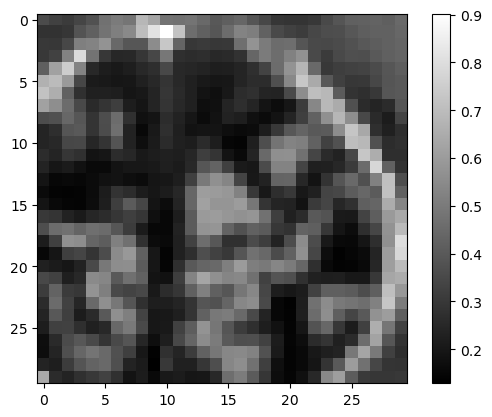

In [19]:
plt.imshow(np.fliplr(np.rot90(signal_norm[30:60:, 30:60, 45, 0])), cmap = 'gray')# , vmin = 0, vmax = 4029)
plt.colorbar()
plt.show()

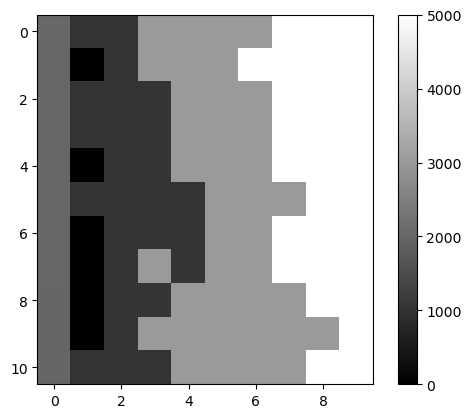

In [ ]:
plt.imshow(np.fliplr(np.rot90(seg[40:50, 40:51, 30])), cmap = 'gray')# , vmin = 0, vmax = 4029)
plt.colorbar()
plt.show()


In [10]:
theta1 = np.linspace(0, 3, 50)
theta2 = np.linspace(0, 40, 50)
thetas, weights = bf.Cartesian(theta1, theta2)
R = rr.R_cube_2D(10, 11, 12, 25, order = 2)

AttributeError: module 'R_roughness' has no attribute 'R_cube_2D'

In [ ]:
std_vector = 0.02*np.ones(len(Sqs))
sigma = np.repeat(std_vector, 25)

for i in range(1):
    _, f_est, _ = das.admm( qs_norm, thetas, weights, Sqs, sigma = sigma,
                            R_csr = sp.csr_matrix(R.shape), f0 = None, normalize = True,
                            Lambdas = None, rho = 1, rho_ratio = 10, dynamic_rho = True, 
                            beta = 0.5, c = 1e-4, tol = 1e-2, epsilon = 1e-8, maxiter = 10,
                            cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000, 
                            admm_tol = 1e-10, admm_maxiter = 200)

    Sqs_est = bf.get_Sqs(bf.kernel(qs_norm, thetas), weights, f_est)

    diff = Sqs - Sqs_est
    std_vector = np.std(diff, axis = 1)
    sigma = np.repeat(std_vector, 25)


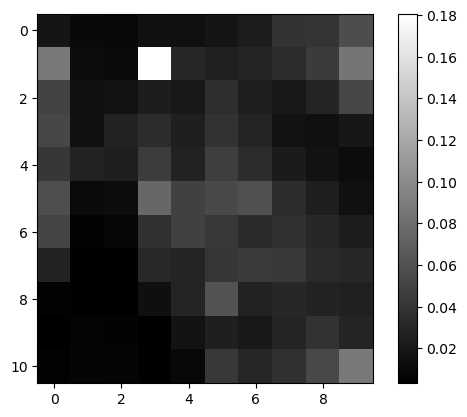

In [ ]:
plt.imshow(np.fliplr(np.rot90(std_vector.reshape((10, 11, 12))[:, :, 0])), cmap = 'gray')
plt.colorbar()


In [ ]:
sigma[sigma <= 0.01] = 0.01
print("Mean of sigma is:", np.mean(sigma))

Mean of sigma is: 0.020221554029359996


In [ ]:
lambdas, f_hat, obj_history = das.admm( qs_norm, thetas, weights, Sqs, sigma = sigma,
                                        R_csr = R, f0 = None, normalize = True,
                                        Lambdas = None, rho = 1, rho_ratio = 3,dynamic_rho = True,
                                        beta = 0.5, c = 1e-4, tol = 1e-2, epsilon = 1e-8, maxiter = 10,
                                        cg_rtol = 1e-10, cg_atol = 1e-50, cg_maxiter = 1000, 
                                        admm_tol = 1e-10, admm_maxiter = 200)


8.563846085642663e-11 3.105283703226995e-11



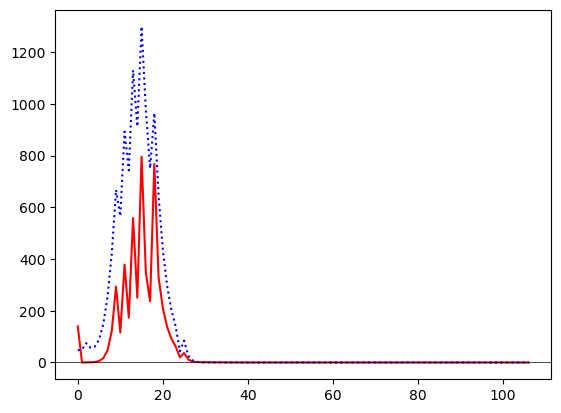

In [ ]:
plt.plot(obj_history[1][:], '-', color = 'red', label = 'primal')
plt.plot(obj_history[2][:], ':', color = 'blue', label = 'dual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
print(obj_history[1][-1], obj_history[2][-1])
print()

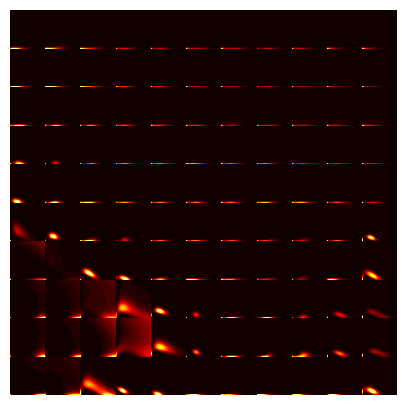

In [ ]:
f_reshaped = f_hat.reshape((10, 11, 12, -1), order = 'C')

rows = 10
cols = 11
fig, axs = plt.subplots(rows, cols, figsize=(5, 5)) 
plt.subplots_adjust(wspace=0, hspace=0)
theta11, theta22 = np.meshgrid(theta1, theta2)

for i in range(rows):
    for j in range(cols):
        ax = axs[i,j]
        ax.contourf(theta11, theta22, f_reshaped[i, j, 0, :].reshape(theta11.shape, order='F'), levels=50, cmap='hot')
        # ax.axvline(x=0)
        # ax.axhline(y=0)
        # ax.text(0.02, 0.02, f'{15*(14 - i)+(14 - j)}', color='white', fontsize=8,
        #         transform=ax.transAxes, ha='left', va='bottom')
        ax.axis("off")
plt.show()

# Compare

In [ ]:
import torch
hpc = torch.load("/Users/xunan/Downloads/run_checkpoint-realcube.pt", map_location="cpu")
print(type(hpc))
print(hpc.keys() if isinstance(hpc, dict) else hpc.shape)

<class 'dict'>
dict_keys(['lambdas', 'f_hat', 'obj_history'])


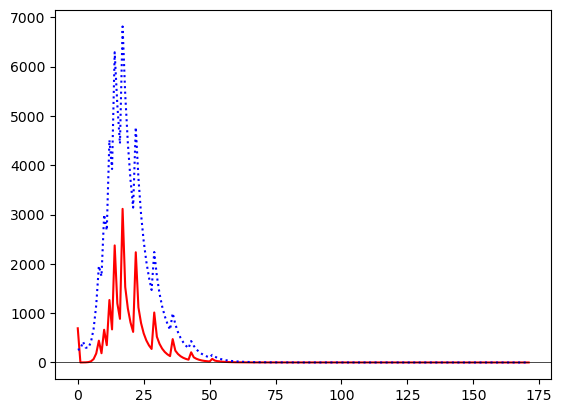

In [ ]:
plt.plot(hpc['obj_history'][1][:], '-', color = 'red', label = 'primal')
plt.plot(hpc['obj_history'][2][:], ':', color = 'blue', label = 'dual')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

In [ ]:
f_reshaped = hpc['f_hat'].numpy().reshape((35, 40, 25, -1), order = 'C')

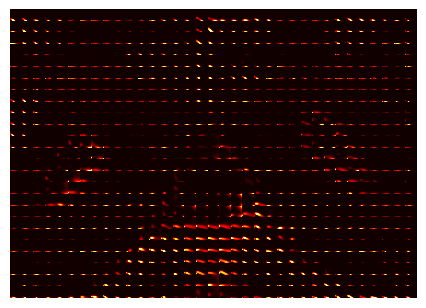

In [ ]:
rows = 25
cols = 35
fig, axs = plt.subplots(rows, cols, figsize=(cols/10*1.5, rows/10*1.5)) 
plt.subplots_adjust(wspace=0, hspace=0)
theta11, theta22 = np.meshgrid(theta1, theta2)

for j in range(cols):
    for i in range(rows):
        ax = axs[i,j]
        ax.contourf(theta11, theta22, f_reshaped[cols-1-j, 10, rows-1-i, :].reshape(theta11.shape, order='F'), levels=50, cmap='hot')
        # ax.axvline(x=0)
        # ax.axhline(y=0)
        ax.axis("off")
plt.show()